In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
import numpy as np

#### temporal kernel in time domain (IFT from Bernadete and Kaplan 1997)
$$f(t)=A\left(\frac{1}{(N_{L}-1)!}\frac{t^{N_{L}-1}}{\tau_{L}^{N_L}}+\frac{H_{S}}{\tau_{S}}\left(\frac{\tau_{M}}{\tau_{L}}\right)^{N_{L}}\sum_{i=0}^{N_{L}-1}{\frac{1}{i!}\left(\frac{t}{\tau_{M}}\right)^{i}}\right)e^{-t/\tau_{L}} - \frac{H_{S}}{\tau_{S}}\left(\frac{\tau_{M}}{\tau_{L}}\right)^{N_{L}}e^{-t/\tau_{S}}$$
#### fitted by generalized alpha function
$$f(t) = \frac{A_{r}}{(n_{r}-1)!}\frac{t^{n_{r}-1}}{\tau_{r}^{n_{r}}}e^{-t/\tau_{r}} + \frac{A_{d}}{(n_{d}-1)!}\frac{t^{n_{d}-1}}{\tau_{d}^{n_{d}}}e^{-t/\tau_{d}}$$

$n_{r}, n_{d}$ to match the coefficient of variance with $N_{L}$,

$A_{r}, A_{d} \to A$

$\tau_{r} \to \tau_{L}$

$\tau_{d} \to \tau_{S}$


In [3]:
from scipy.special import gamma
np.seterr(over='raise')
def temporalKernel(A, HS, tauS, NL, tauL, D, t):
    t = t - D
    tpick = t > 0
    active_t = t[tpick]
    Kt = np.zeros(t.shape)
    sums = np.zeros(t.shape)
    
    tauM = tauS*tauL/(tauS-tauL)
    B = HS/tauS*np.float_power(tauM/tauL,NL)
    NL_int = np.ceil(NL).astype(int)
    for i in range(NL_int):
        if i == NL_int-2 and NL_int > NL:
            r = (NL - NL_int + 1)
        else:
            r = 1
        sums[tpick] = sums[tpick] + r * np.power(active_t/tauM,i)/np.math.factorial(i)
        
    Kt[tpick] = A*((np.float_power(active_t/tauL,NL-1)/tauL/gamma(NL) + B*sums[tpick]) * np.exp(-active_t/tauL) - B*np.exp(-active_t/tauS))
    return Kt

def temporalComp(A,tau,n,d,t):
    #fac = np.math.factorial(n-1)
    fac = gamma(n)
    t = t-d
    Kt = np.zeros(t.shape)
    tpick = t>0
    active_t = t[tpick]
    Kt[tpick] = A*np.float_power((active_t/tau),(n-1))/tau/fac*np.exp(-active_t/tau)
    return Kt

def temporalSimple(Ar, Ad, tauR, tauD, nR, nD, d0, dd, t):
    Kc = temporalComp(Ar,tauR,nR,d0,t)
    Ks = temporalComp(Ad,tauD,nD,d0+dd,t)
    Kt = Kc - Ks
    return Kt, Kc, Ks

def plotKernel(Ar, Ad, tauR, tauD, nR, nD, D0, Dd, K0, t, ax, c0, c1, dissect = False):
    Kt, Kc, Ks = temporalSimple(Ar, Ad, tauR, tauD, nR, nD, D0, Dd, t)
    if dissect:
        ax.plot(t,Kc,'b')
        ax.plot(t,-Ks,'k')
    ax.plot(t,K0, c0)
    ax.plot(t,Kt, c1)

def tKFourier(A, HS, tauS, NL, tauL, D, w):
    Ft = A*np.exp(-1j*w*D)*(1-HS/(1+1j*w*tauS))/(1+1j*w*tauL)**NL
    return Ft

def spatialKernel(kc, ks, rc, rs, x, y):
    Ks = kc*np.exp(-((x-xc)/rc)**2) + ks*np.exp(-((x-xs)/rs)**2)
    return Ks

def sKFourier(k, r, v):
    Fs = kc*rc*np.exp(-(np.pi*rc*v)**2)
    return Fs

In [4]:
t = np.arange(1000)/1000*200
# Benardete and Kaplan 1997 table 3 P cell center
# On
A = 67.59
NL_tauL = 48.15
NL = 38
HS = 0.69
tauS = 29.36
tauL = NL_tauL/NL
Don = 3.5
Kt_onC = temporalKernel(A, HS, tauS, NL, tauL, Don, t)
# Off
A = 52.95
NL_tauL = 50.38
NL = 27
HS = 0.75
tauS = 35.68
tauL = NL_tauL/NL
Doff = 3.5
Kt_offC = temporalKernel(A, HS, tauS, NL, tauL, Doff, t)
# All
A = 54.57
NL_tauL = 48.87
NL = 31.5
HS = 0.73
tauS = 32.27
tauL = NL_tauL/NL
Dall = 3.5
Kt_allC = temporalKernel(A, HS, tauS, NL, tauL, Dall, t)

[ 62.3664922   39.48227036   0.8240476    6.2018789   82.64484154
  15.21653261 -17.68883965]


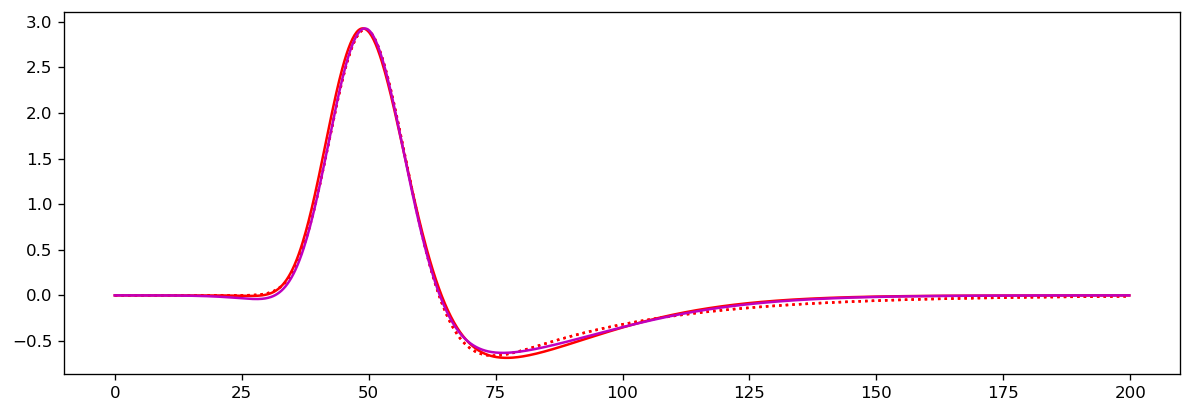

In [11]:
from scipy.optimize import curve_fit
fig = plt.figure('temporal-P_center', figsize=(12,4), dpi=120)
ax = fig.add_subplot(111)
#ax1 = fig.add_subplot(131)
#ax2 = fig.add_subplot(132)
#ax3 = fig.add_subplot(133)

Dt_PonC = Don + Don
Ar_PonC = 64.5
tauR_PonC = 1.42
nR_PonC = 30.82
Ad_PonC = 40.0
tauD_PonC = 6.9
nD_PonC = 10.2

plotKernel(Ar_PonC, Ad_PonC, tauR_PonC, tauD_PonC, nR_PonC, nD_PonC, Dt_PonC, 0, Kt_onC, t, ax, ':r', 'r') 
p0 = np.array([Ar_PonC, Ad_PonC, tauR_PonC, tauD_PonC, nR_PonC, nD_PonC, Dt_PonC])
xdata = t
ydata = Kt_onC

def kernelForFit(t, Ar, Ad, tauR, tauD, nR, nD, d0):
    Kc, _, _ = temporalSimple(Ar, Ad, tauR, tauD, nR, nD, d0, 0, t)
    return Kc

pfit, _ = curve_fit(kernelForFit, xdata, ydata, p0)
print(pfit)
Ar_PonC = pfit[0]
Ad_PonC = pfit[1]
tauR_PonC = pfit[2]
tauD_PonC = pfit[3]
nR_PonC = pfit[4]
nD_PonC = pfit[5]
Dt_PonC = pfit[6]
plotKernel(Ar_PonC, Ad_PonC, tauR_PonC, tauD_PonC, nR_PonC, nD_PonC, Dt_PonC, 0, Kt_onC, t, ax, ':r', 'm', False)

In [6]:
D0_PonC = 27.5
Dd_PonC = 18
Ar_PonC = 120
tauR_PonC = 5.7
nR_PonC = 5.8
Ad_PonC = 94
tauD_PonC = 7.9
nD_PonC = 3.4
plotKernel(Ar_PonC, Ad_PonC, tauR_PonC, tauD_PonC, nR_PonC, nD_PonC, D0_PonC, Dd_PonC, Kt_onC, t, ax, ':r', 'm', True)

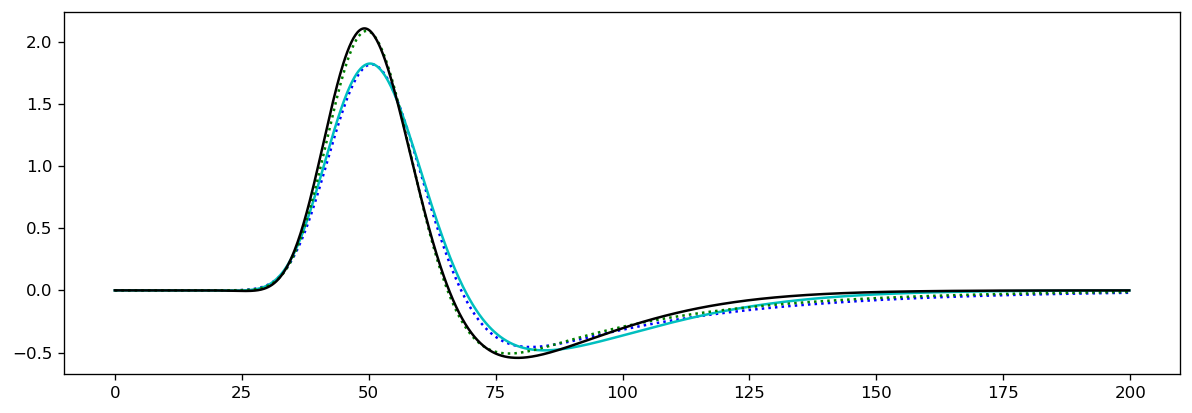

In [10]:
fig = plt.figure('temporal-P_center', figsize=(12,4), dpi=120)
ax = fig.add_subplot(111)
Dt_PoffC = Doff + Doff
Ar_PoffC = 50.3
tauR_PoffC = 2.08
nR_PoffC = 22.18
Ad_PoffC = 33.4
tauD_PoffC = 8.4
nD_PoffC = 9.2
plotKernel(Ar_PoffC, Ad_PoffC, tauR_PoffC, tauD_PoffC, nR_PoffC, nD_PoffC, Dt_PoffC, 0, Kt_offC, t, ax, ':b', 'c')

Dt_PallC = Dall + Dall
Ar_PallC = 53.8
tauR_PallC = 1.75
nR_PallC = 25.5
Ad_PallC = 35.0
tauD_PallC = 7.4
nD_PallC = 9.5
plotKernel(Ar_PallC, Ad_PallC, tauR_PallC, tauD_PallC, nR_PallC, nD_PallC, Dt_PallC, 0, Kt_allC, t, ax, ':g', 'k')
#ax.plot(t+Dall,np.zeros(t.shape),':g')

In [8]:
t = np.arange(1000)/1000*200
# Benardete and Kaplan 1997 table 5 and 6
# center parameters
A = 27.41
HS = 0.73
tauS = 36.95
NL_tauL = 52.32
NL = 26
tauL = NL_tauL/NL
Dc = 3.5+2.95 # P-cell delay + retinogeniculate delay
Kt_c = temporalKernel(A, HS, tauS, NL, tauL, t)

TypeError: temporalKernel() missing 1 required positional argument: 't'

LGN On-center: K = 29.132899628252794, ratio = 0.5688218056865774, tauR = 1.8987428571428568, tauD = 6.34054054054054, nR = 23.20564705882353, nD = 12.562105263157894, delay = 6.45
LGN Off-center: K = 22.71914498141264, ratio = 0.6090520954227603, tauR = 2.7812571428571427, tauD = 7.718918918918918, nR = 16.700235294117647, nD = 11.330526315789472, delay = 6.45


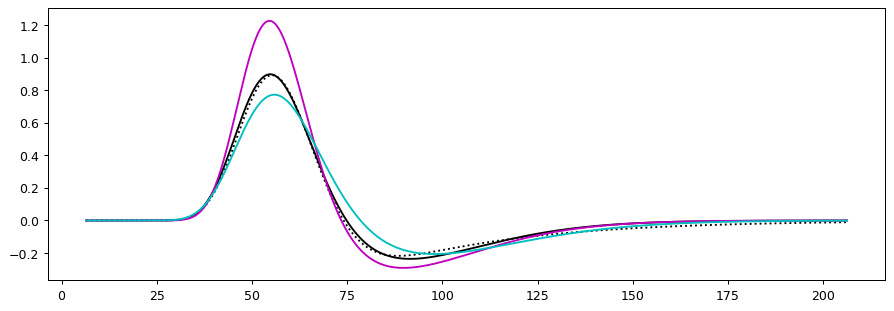

In [524]:
fig = plt.figure('temporal_LGN_C', figsize=(12,4), dpi=90)
ax = fig.add_subplot(111)
Ar_all = 24.3
Ad_all = 14.5
tauR_all = 2.34
tauD_all = 6.8
nR_all = 19.2
nD_all = 11.7
Dt_all = 0 + Dc
#    temporalSimple(Ar, Ad, tauR, tauD, nR, nD, t)
Kt = temporalSimple(Ar_all, Ad_all, tauR_all, tauD_all, nR_all, nD_all,  t-Dt_all)
ax.plot(t+Dc,Kt,'k')
ax.plot(t+Dc,Kt_c,':k')

Ar = Ar_all * Ar_PonC/ Ar_PallC
Ad = Ad_all * Ad_PonC/ Ad_PallC
tauR = tauR_all * tauR_PonC/ tauR_PallC
tauD = tauD_all * tauD_PonC/ tauD_PallC
nR = nR_all * nR_PonC/ nR_PallC
nD = nD_all * nD_PonC/ nD_PallC
Dt = Dt_all * Dt_PonC/ Dt_PallC
Kt = temporalSimple(Ar, Ad, tauR, tauD, nR, nD,  t-Dt)
ax.plot(t+Dc,Kt,'m')
print(f'LGN On-center: K = {Ar}, ratio = {Ad/Ar}, tauR = {tauR}, tauD = {tauD}, nR = {nR}, nD = {nD}, delay = {Dt}')

Ar = Ar_all * Ar_PoffC/ Ar_PallC
Ad = Ad_all * Ad_PoffC/ Ad_PallC
tauR = tauR_all * tauR_PoffC/ tauR_PallC
tauD = tauD_all * tauD_PoffC/ tauD_PallC
nR = nR_all * nR_PoffC/ nR_PallC
nD = nD_all * nD_PoffC/ nD_PallC
Dt = Dt_all * Dt_PoffC/ Dt_PallC
Kt = temporalSimple(Ar, Ad, tauR, tauD, nR, nD,  t-Dt)
ax.plot(t+Dc,Kt,'c')
print(f'LGN Off-center: K = {Ar}, ratio = {Ad/Ar}, tauR = {tauR}, tauD = {tauD}, nR = {nR}, nD = {nD}, delay = {Dt}')

In [38]:
t = np.arange(1000)/1000*200
# Benardete and Kaplan 1997 table 3 P cell surround
# On
A = 49.98
NL_tauL = 55.02
NL = 111
HS = 0.48
tauS = 18.62

tauL = NL_tauL/NL
Don = 3.5
Kt_onS = temporalKernel(A, HS, tauS, NL, tauL, t)
# Off
A = 23.91
NL_tauL = 60.33
NL = 67
HS = 0.42
tauS = 52
tauL = NL_tauL/NL
Doff = 3.5
Kt_offS = temporalKernel(A, HS, tauS, NL, tauL, t)
# All
A = 32.92
NL_tauL = 58.68
NL = 98
HS = 0.45
tauS = 37.08
tauL = NL_tauL/NL
Dall = 3.5
Kt_allS = temporalKernel(A, HS, tauS, NL, tauL, t)

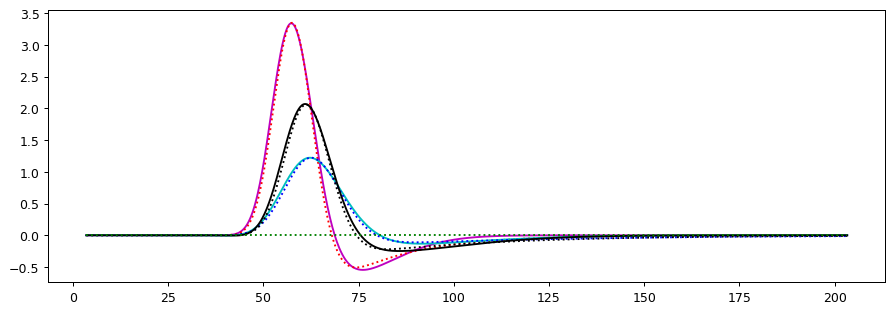

In [427]:
fig = plt.figure('temporal-P_surround', figsize=(12,4), dpi=90)
ax = fig.add_subplot(111)

Dt_PonS = Don + 7.24

Ar_PonS = 49
tauR_PonS = 0.68
nR_PonS = 64.8

Ad_PonS = 18.4
tauD_PonS = 2.4
nD_PonS = 25

Kt = temporalSimple(Ar_PonS, Ad_PonS, tauR_PonS, tauD_PonS, nR_PonS, nD_PonS, t-Dt_PonS)
ax.plot(t+Don,Kt,'m')
ax.plot(t+Don,Kt_onS,':r')

Dt_PoffS = Doff + 10.22

Ar_PoffS = 26.5
tauR_PoffS = 1.38
nR_PoffS = 33.8

Ad_PoffS = 9.1
tauD_PoffS = 7.6
nD_PoffS = 9.2

Kt = temporalSimple(Ar_PoffS, Ad_PoffS, tauR_PoffS, tauD_PoffS, nR_PoffS, nD_PoffS, t-Dt_PoffS)
ax.plot(t+Doff,Kt,'c')
ax.plot(t+Doff,Kt_offS,':b')

Dt_PallS = Dall + 7.52

Ar_PallS = 35.1
tauR_PallS = 0.857
nR_PallS = 55.4

Ad_PallS = 13.2
tauD_PallS = 5.9
nD_PallS = 12.2

Kt = temporalSimple(Ar_PallS, Ad_PallS, tauR_PallS, tauD_PallS, nR_PallS, nD_PallS, t-Dt_PallS)
ax.plot(t+Dall,Kt,'k')
ax.plot(t+Dall,Kt_allS,':k')
ax.plot(t+Don,np.zeros(t.shape),':g')

In [530]:
# surround parameters
A = 17.07
HS = 0.46
tauS = 46.30
NL_tauL = 60.53
NL = 66
tauL = NL_tauL/NL
Ds = 3.5 + 1.21 + 6.77
Kt_s = temporalKernel(A, HS, tauS, NL, tauL, t)

LGN On-surround: K = 26.663817663817664, ratio = 0.38163168170647604, tauR = 1.0870478413068847, tauD = 2.806779661016949, nR = 41.991335740072195, nD = 21.516393442622952, delay = 11.18831215970962
LGN Off-surround: K = 14.420227920227921, ratio = 0.3489941896491338, tauR = 2.2060676779463244, tauD = 8.888135593220339, nR = 21.902888086642598, nD = 7.918032786885246, delay = 14.292704174228676


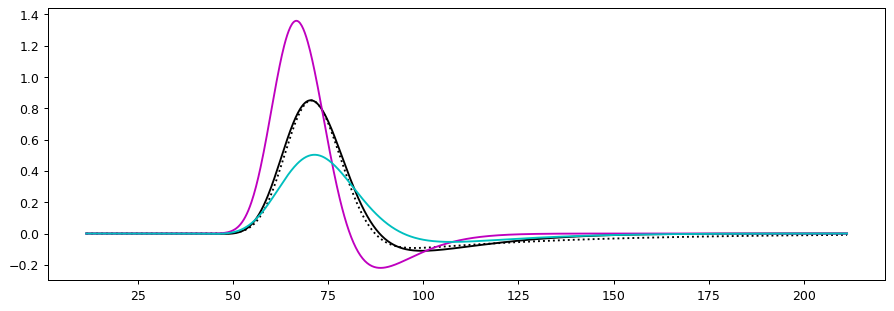

In [531]:
fig = plt.figure('temporal_LGN_S', figsize = (12,4), dpi=90)
ax = fig.add_subplot(111)

Ar_all = 19.1
Ad_all = 7.3
tauR_all = 1.37
tauD_all = 6.9
nR_all = 35.9
nD_all = 10.5
Dt_all = 0 + Ds

Kt = temporalSimple(Ar_all, Ad_all, tauR_all, tauD_all,  nR_all,  nD_all,  t-Dt_all)
ax.plot(t+Ds,Kt,'k')
ax.plot(t+Ds,Kt_s,':k')

Ar = Ar_all * Ar_PonS/ Ar_PallS
Ad = Ad_all * Ad_PonS/ Ad_PallS
tauR = tauR_all * tauR_PonS/ tauR_PallS
tauD = tauD_all * tauD_PonS/ tauD_PallS
nR = nR_all * nR_PonS/ nR_PallS
nD = nD_all * nD_PonS/ nD_PallS
Dt = Dt_all * Dt_PonS/ Dt_PallS
Kt = temporalSimple(Ar, Ad, tauR, tauD, nR, nD,  t-Dt)
ax.plot(t+Ds,Kt,'m')
print(f'LGN On-surround: K = {Ar}, ratio = {Ad/Ar}, tauR = {tauR}, tauD = {tauD}, nR = {nR}, nD = {nD}, delay = {Dt}')
Ar = Ar_all * Ar_PoffS/ Ar_PallS
Ad = Ad_all * Ad_PoffS/ Ad_PallS
tauR = tauR_all * tauR_PoffS/ tauR_PallS
tauD = tauD_all * tauD_PoffS/ tauD_PallS
nR = nR_all * nR_PoffS/ nR_PallS
nD = nD_all * nD_PoffS/ nD_PallS
Dt = Dt_all * Dt_PoffS/ Dt_PallS
Kt = temporalSimple(Ar, Ad, tauR, tauD, nR, nD,  t-Dt)
ax.plot(t+Ds,Kt,'c')
print(f'LGN Off-surround: K = {Ar}, ratio = {Ad/Ar}, tauR = {tauR}, tauD = {tauD}, nR = {nR}, nD = {nD}, delay = {Dt}')

In [ ]:
# P-on, P-off, P-all, LGN-all # center
t = np.arange(1000)/1000*200
# Benardete and Kaplan 1997 table 3 P cell center
# On
A = 67.59
HS = 0.69
tauS = 29.36
NL_tauL = 48.15
NL = 38
tauL = NL_tauL/NL
Dc = 3.5
Kt_on = temporalKernel(A, HS, tauS, NL, tauL, t)
# Off
A = 52.95
HS = 0.75
tauS = 35.68
NL_tauL = 50.38
NL = 27
tauL = NL_tauL/NL
Ds = 3.5
Kt_off = temporalKernel(A, HS, tauS, NL, tauL, t)
# all
A = 54.57
HS = 0.73
tauS = 32.27
NL_tauL = 48.87
NL = 31.5
tauL = NL_tauL/NL
Ds = 3.5
Kt_all = temporalKernel(A, HS, tauS, NL, tauL, t)
# center parameters
A = 27.41
HS = 0.73
tauS = 36.95
NL_tauL = 52.32
NL = 26
tauL = NL_tauL/NL
Dc = 3.5+2.95 # P-cell delay + retinogeniculate delay
Kt_LGN = temporalKernel(A, HS, tauS, NL, tauL, t)

fig = plt.figure('temporal-centers', dpi=90)
ax = fig.add_subplot(111)
ax.plot(t,Kt_on,':r')
ax.plot(t,Kt_off,':b')
ax.plot(t,Kt_all,'g')
ax.plot(t,Kt_LGN,'k')